In [1]:
# setup + imports
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import dask.dataframe as dd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import vaex
import warnings
from scipy.stats import iqr

warnings.filterwarnings('ignore') # suppress annoying deprecation warnings
sns.set(style='white', font_scale=1.2)

In [2]:
# read in all HLC data and add columns
df = dd.read_hdf('stripe82/HLC*.hdf5', key='data') 
df = df.assign(U_G_COLOR=df.U_MEAN_EXPMAG - df.G_MEAN_EXPMAG)
df = df.assign(G_R_COLOR=df.G_MEAN_EXPMAG - df.R_MEAN_EXPMAG)
df = df.assign(G_I_COLOR=df.G_MEAN_EXPMAG - df.I_MEAN_EXPMAG)
df = df.assign(PM_TOT = (df.RA_PM**2 + df.DEC_PM**2)**0.5)
df = df.assign(PM_TOT_ERR = (df.RA_PM_ERR**2 + df.DEC_PM_ERR**2)**0.5)

# select specified color and magnitude bins for stars
query_str_a = '(R_MEAN_EXPMAG > 20.5) & (R_MEAN_EXPMAG < 21) & (G_I_COLOR > 0.3)\
& (G_I_COLOR < 0.4) & (MEAN_OBJECT_TYPE > 5)'
ds_a = vaex.from_pandas(df.query(query_str_a).compute())

### a) please see the r vs. RA diagram for stars with 0.3<g-i<0.4, color-coded by the median FeH, in page 49 (top left corner) in http://faculty.washington.edu/ivezic/Teaching/Astr511/lec8.pdf

### For stars with 20.5 < r < 21, 0.3<g-i<0.4, compare pm distribution for bins 25 < RA < 40 and 0 < RA < 15

In [3]:
extent_0_15 = np.array([[0,15],[21,20.5]])
extent_25_40 = np.array([[25,40],[21,20.5]])
med_0_15 = ds_a.median_approx('PM_TOT', binby=['RA_MEAN', 'R_MEAN_EXPMAG'],
                              limits=extent_0_15, shape=12)
med_25_40 = ds_a.median_approx('PM_TOT', binby=['RA_MEAN', 'R_MEAN_EXPMAG'],
                               limits=extent_25_40, shape=12)

Text(24.8918,0.5,'R mag')

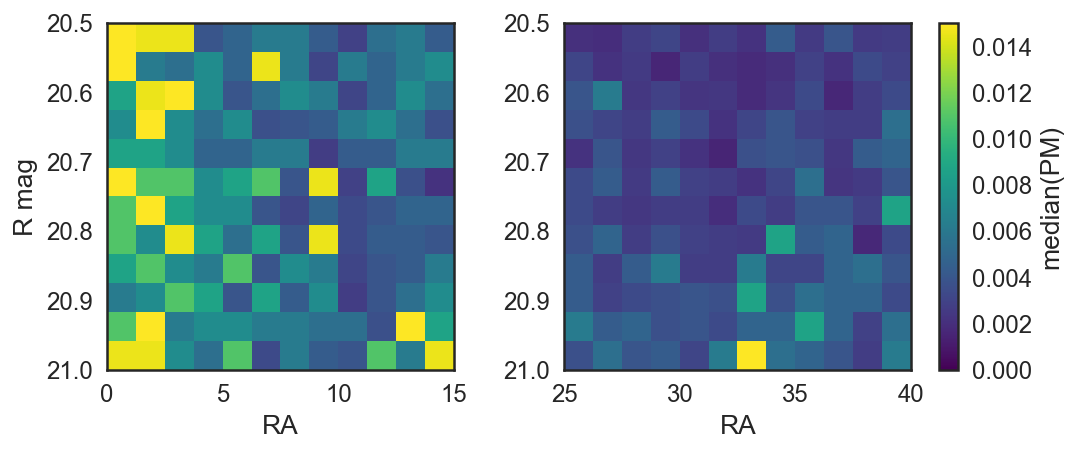

In [4]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(6.5,3))
im = ax1.imshow(med_0_15.T, vmin=0, vmax=0.015, cmap='viridis',
                extent=extent_0_15.ravel(), aspect=30)
ax2.imshow(med_25_40.T, vmin=0, vmax=0.015, cmap='viridis',
           extent=extent_25_40.ravel(), aspect=30)
fig.tight_layout()
pos = ax2.get_position()
cax = fig.add_axes([pos.x1+0.02, pos.y0, 0.02, pos.height])
fig.colorbar(im, cax=cax, label='median(PM)')
ax1.set_xlabel('RA')
ax2.set_xlabel('RA')
ax1.set_ylabel('R mag')

### b) Estimate systematic proper motion errors in HLC and NSC by analyzing the proper motion distributions and chi=pm/pmErr distributions (in both coordinates) for galaxies; if the medians are significantly different from 0, plot them as functions of R.A. 

In [5]:
# select galaxies only
query_str_b = '(MEAN_OBJECT_TYPE < 5)'
ds_b = vaex.from_pandas(df.query(query_str_b).compute())

(0.0, 0.0)

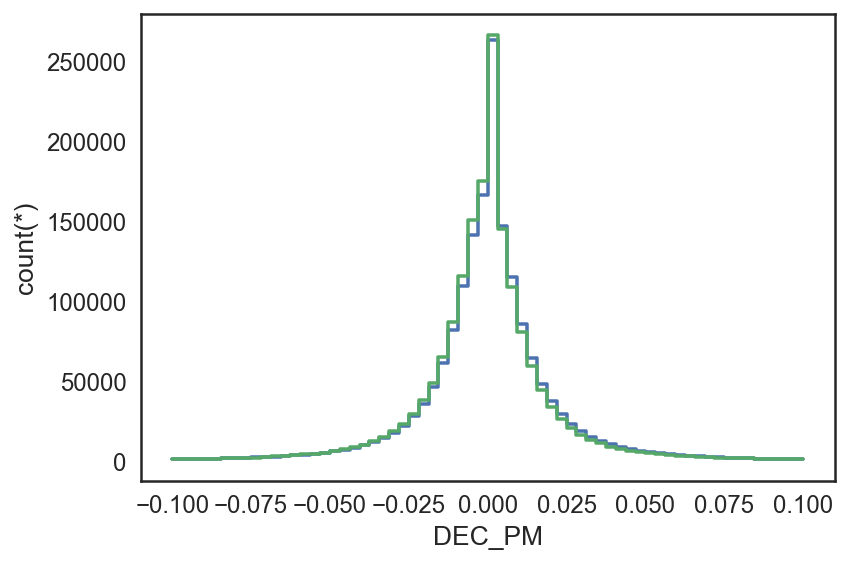

In [6]:
ds_b.plot1d('RA_PM', limits=[-0.1,0.1])
ds_b.plot1d('DEC_PM', limits=[-0.1,0.1])
np.median(ds_b.RA_PM.tolist()), np.median(ds_b.DEC_PM.tolist())

(0.057752437889575958, -0.088933512568473816)

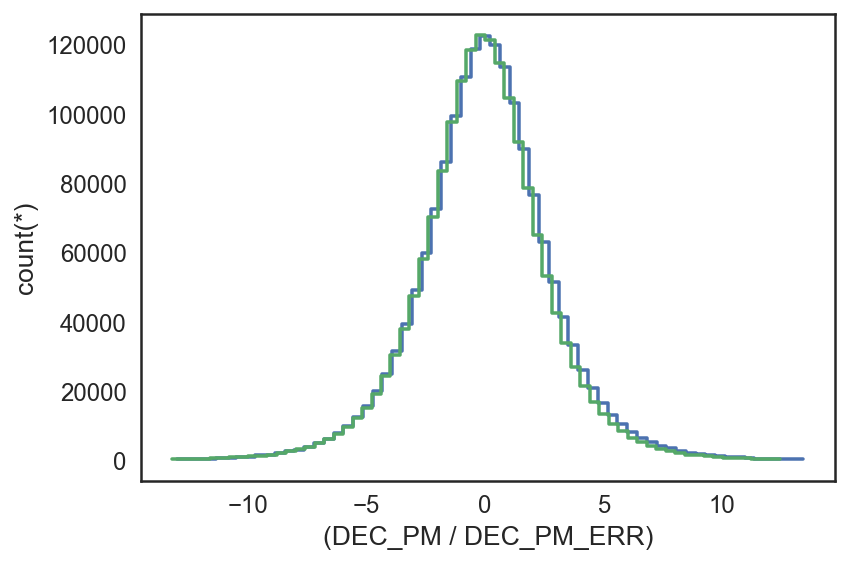

In [7]:
ds_b.plot1d(ds_b.RA_PM/ds_b.RA_PM_ERR)
ds_b.plot1d(ds_b.DEC_PM/ds_b.DEC_PM_ERR)
(np.nanmedian((ds_b.RA_PM/ds_b.RA_PM_ERR).tolist()), 
np.nanmedian((ds_b.DEC_PM/ds_b.DEC_PM_ERR).tolist()))

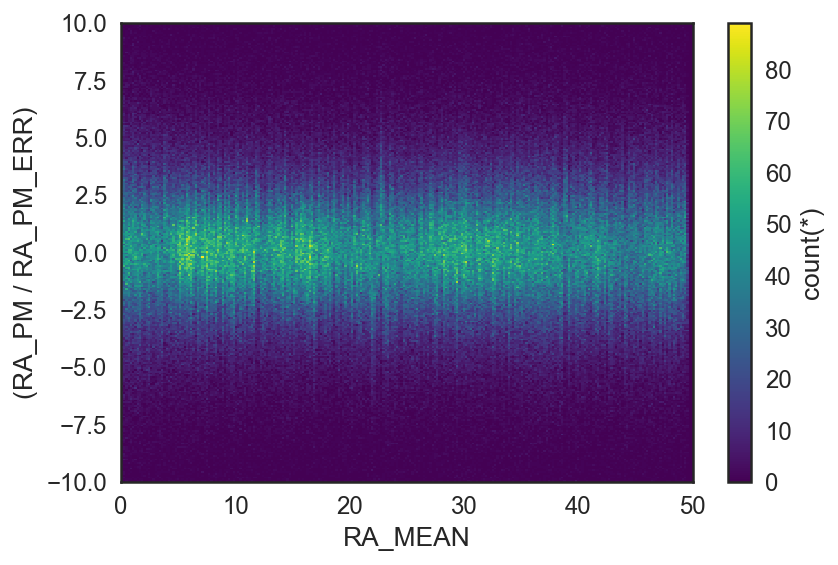

In [8]:
ds_b.plot(ds_b.RA_MEAN, ds_b.RA_PM/ds_b.RA_PM_ERR,
          limits=[[0,50],[-10,10]], colormap='viridis')

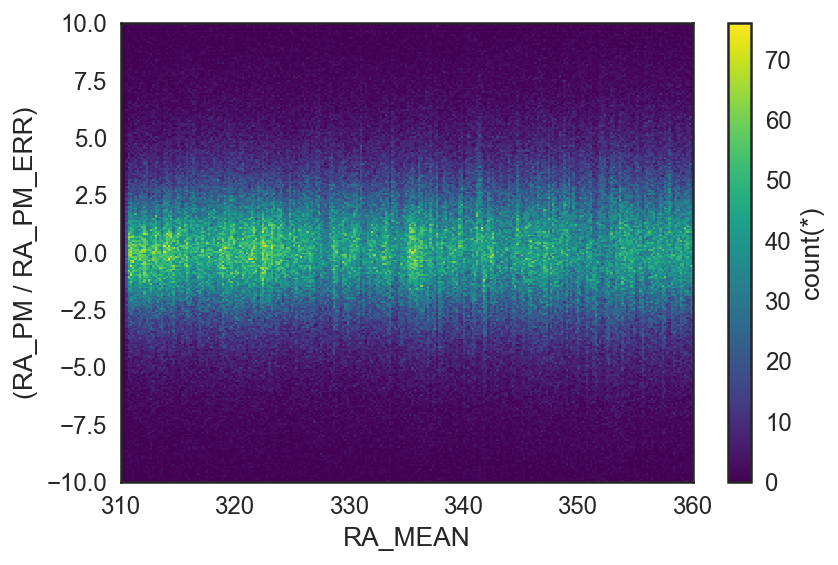

In [9]:
ds_b.plot(ds_b.RA_MEAN, ds_b.RA_PM/ds_b.RA_PM_ERR,
          limits=[[310,360],[-10,10]], colormap='viridis')

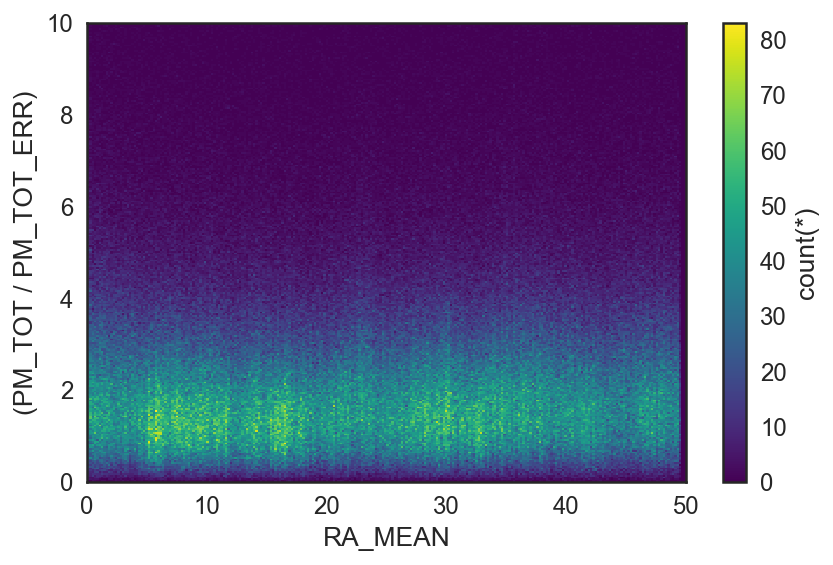

In [10]:
ds_b.plot(ds_b.RA_MEAN, ds_b.PM_TOT/ds_b.PM_TOT_ERR,
          limits=[[0,50],[0,10]], colormap='viridis')

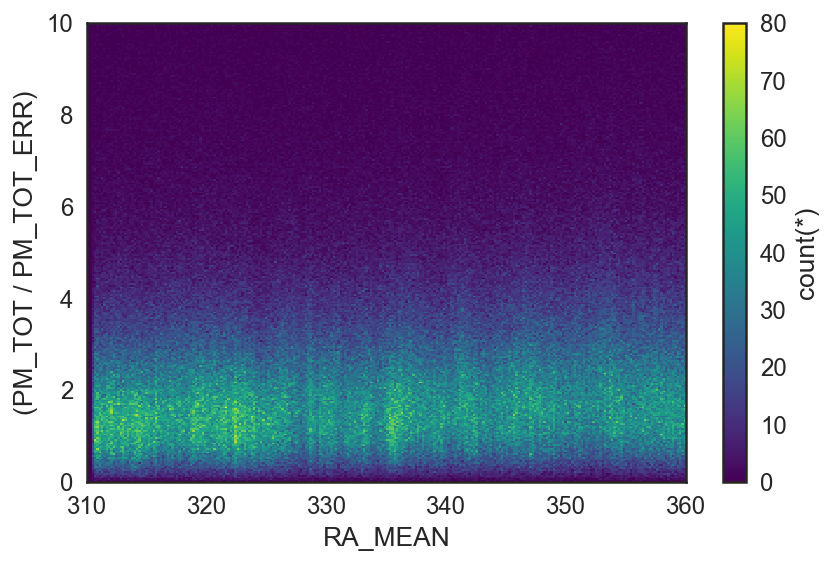

In [11]:
ds_b.plot(ds_b.RA_MEAN, ds_b.PM_TOT/ds_b.PM_TOT_ERR,
          limits=[[310,360],[0,10]], colormap='viridis')


### c)  Systematic errors in HLC, NSC (and joint) proper motions can be also be gauged using ~10,000 quasars from the catalog DR12Q.fits from http://www.sdss.org/dr12/algorithms/boss-dr12-quasar-catalog/

### Plot the median and sigmaG vs. RA for RA and Dec proper motion components for quasars with 17 < r < 20 from that file (~1 deg wide bins in RA, but try a factor of 3 smaller and larger bins and discuss). 

My code for matching quasars is in another notebook.



In [12]:
query_str_q = '(R_MEAN_EXPMAG > 17) & (R_MEAN_EXPMAG < 20)'
df_q = pd.read_hdf('stripe82/quasars_matched.hdf5', key='data').query(query_str_q)

In [13]:
def sigmaG(x):
    return 2*0.7413*iqr(x)/x.shape[0]**(1/3)

def plot_group(df_q, nbins, ylim=[-0.013,0.013]):
    bin_edges = np.linspace(0,360,nbins+1)
    scale_fac = nbins/360
    bin_centers = (bin_edges[:-1] + bin_edges[1:])/2
    grouped = df_q.groupby(pd.cut(df_q.RA_MEAN, bins=bin_edges, labels=bin_centers))
    medians = grouped[['RA_PM','DEC_PM']].median()
    sigg = grouped[['RA_PM','DEC_PM']].agg(sigmaG)
    
    fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10,4), sharey=True)
    medians.plot(yerr=sigg, ax=ax1, fmt='.-', ylim=ylim,
                 xlim=[-5*scale_fac,47*scale_fac],
                 xticks=np.array([0,10,20,30,40])*scale_fac)
    ax1.set_xticklabels([0,10,20,30,40])
    ax1.axhline(0, linestyle='--', color='k')
    
    medians.plot(yerr=sigg, ax=ax2, fmt='.-', ylim=ylim,
                 xlim=[314*scale_fac,362*scale_fac],
                 xticks=np.array([320,330,340,350,360])*scale_fac)
    ax2.set_xticklabels([320,330,340,350,360])
    ax2.axhline(0, linestyle='--', color='k')
    fig.tight_layout()

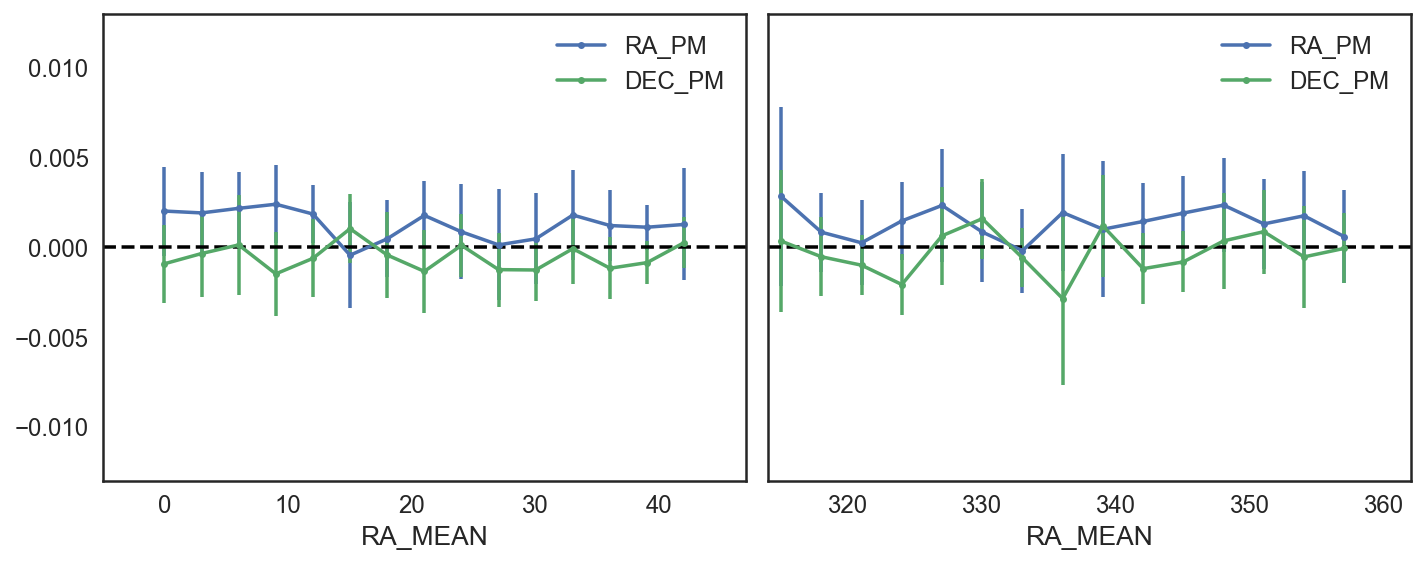

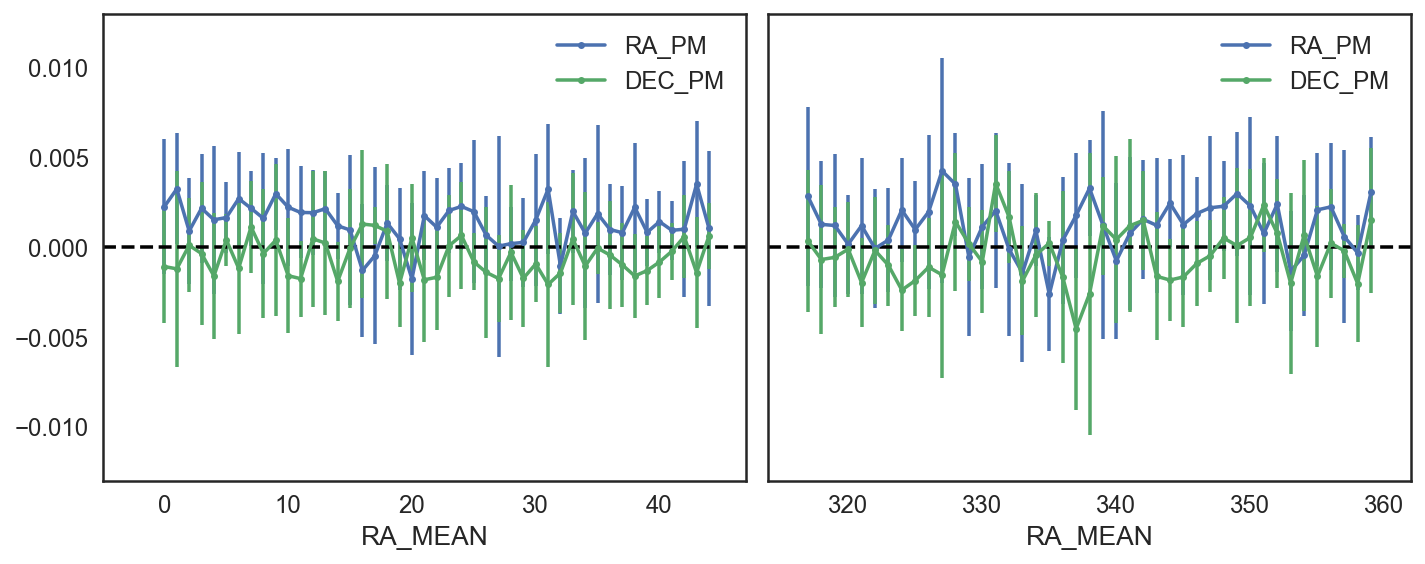

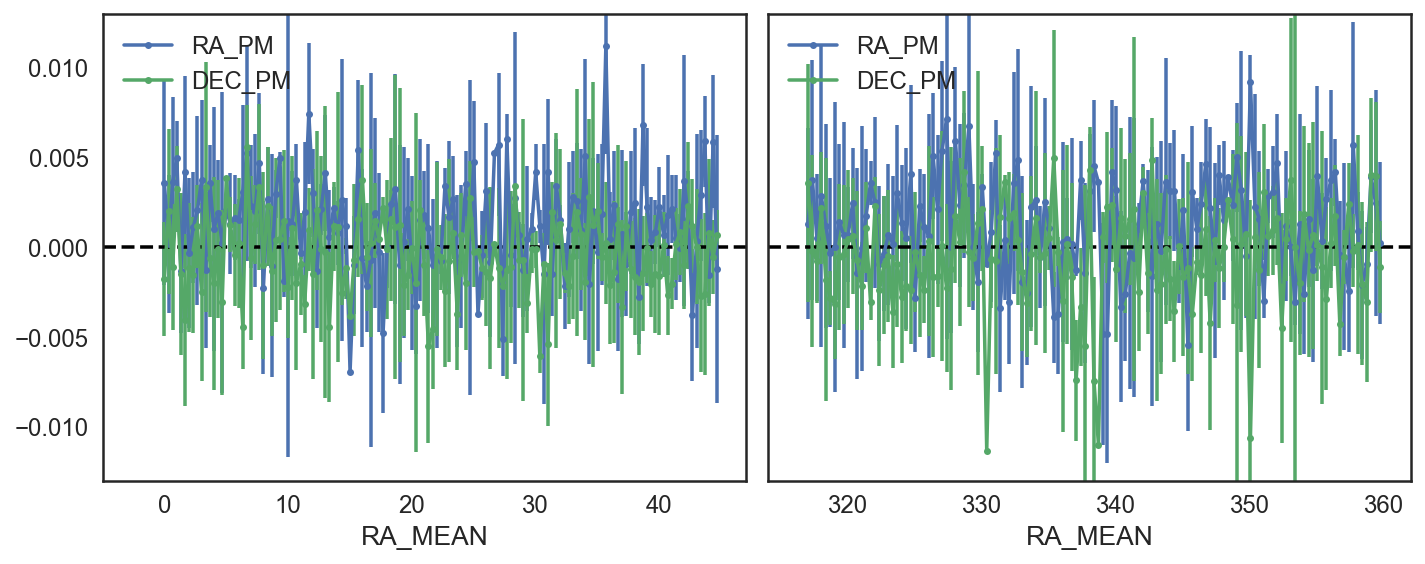

In [14]:
plot_group(df_q, 120)
plot_group(df_q, 360)
plot_group(df_q, 1080)

There appears to be a very small systematic overestimation of RA proper motions, and an even smaller systematic underestimation of Dec proper motions.